The objective of this workbook is to build, evaluate, compare, and contrast the ensemble models with standard machine learning models. Four ensemble models, including Random Forest, AdaBoost, Bagging Classifier, and Voting Classifier, are compared against the baseline models (Logistic Regression and k-NN model) based on their model performance and computing resources requirement.

The analysis was done using the Term Marketing - Banking dataset from Kaggle. It is related to the direct marketing campaigns of a Portuguese banking institution. The goal of the model is to predict whether the client will subscribe to a term deposit. Please refer to the website following website for the data definition of each variable.

https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets

In the following sections, we first clean and explore the data and perform data transformation required. Then, we build the baseline models with hyperparameter tuning to set the baseline of comparison. After that, we build the four ensemble models and evaluate their performance. Lastly, we interpret the comparison results and suggest the model which is the most suitable to the business.

The comparison on score and computing resources suggests that Logistic Regression generate the optimal results, i.e., relatively high F1 score with less computing resources. Please refer to part 5A for more details on the model comparison.

We suggest the business to use F1 score which measure both precision and recall. This is because they need to balance between the effectiveness of the campaign (i.e. how many actual term deposit subscription covered by the prediction) and efficiency of the campaign (i.e. how much call center costs is wasted). Please refer to part 5B and 5C for the recommendations and explanation on the decision criteria.

Since the F1 score of the model is not high, we recommend the business to collect additional attributes of the client to improve the predictability. Nevertheless, the accuracy of the suggested model is 75% which is better than random guess.

In [17]:
# import relevant library for data cleaning
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
# import the data
df = pd.read_csv(r"C:\Users\samue\OneDrive\Desktop\MBAN6120U_Data Science 2\Assignment_1\train.csv", delimiter=";")

#### Part 1A: Clean and explore the data

First, we explore the data by reviewing the first few rows and the information of each column.

In [19]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


The first few rows show that certain columns have unknown value. The column summary shows that the no. of non-null value is the same as the number of entries. Thus, we need to investigate for the columns with unknown value.

In [21]:
# using the lambda function and eq() method to count the 'unknown' value
unknown = pd.DataFrame(df.apply(lambda col: col.eq('unknown').sum()))
# calculate the percentage of unknown value
unknown['Percent'] = unknown.values / len(df)
unknown

,0,Percent
age,0,0.000000
job,288,0.006370
marital,0,0.000000
education,1857,0.041074
default,0,0.000000
balance,0,0.000000
housing,0,0.000000
loan,0,0.000000
contact,13020,0.287983
day,0,0.000000


The above summary indicates that the unknown value under both 'job' and 'education' are less than 5%.  Hence, we propose to remove them in view of their immateriality.

'Contact' represents the communication type, which could be telephone or cellular. 'poutcome' represents the outcome of previous marketing campaign. We will explore the relationship between these two valuables against the target value before deciding how to handle the unknown value.

'Duration' represents the duration of the last call. Since the call duration would not known before calling the client (i.e., a post-facto), it would not help to predict the outcome before making the call. Hence, we will exclude it in building our prediction model. However, this data could be used for evaluating the relationship between duration and success rate and hence the performance of the telemarketer.

contact  cellular  telephone  unknown
y                                    
no          24916       2516    12490
yes          4369        390      530


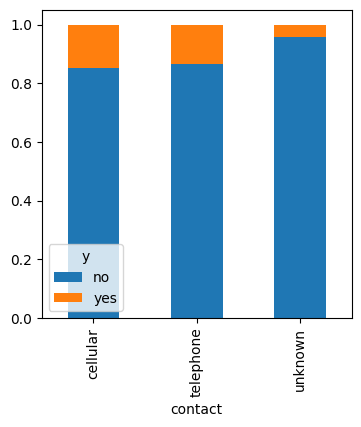

poutcome  failure  other  success  unknown
y                                         
no           4283   1533      533    33573
yes           618    307      978     3386


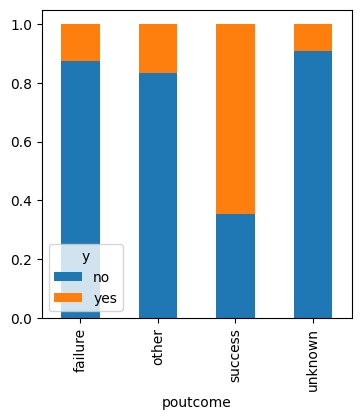

In [22]:
for i in ['contact','poutcome']:
    print(df.groupby(['y',i])['age'].count().unstack())
    df.groupby([i])['y'].value_counts(normalize=True).unstack().plot.bar(stacked=True, figsize=(4,4))
    plt.show()

For contact channel, the proportion of success case is similar between cellular and telephone.  Given the cellular vs telephone does not provide much information about the success rate and almost one-third of the value is 'unknown'.  We propose to drop it.

For 'poutcome', the success rate is similar between 'failure' and 'other' while that of 'success' is much higher. Given the success rate of 'unknown' is relatively low, we propose to group it under 'other' category.

In [23]:

# drop the 'unknown' value under 'job' and 'education' column
to_drop = list(df[df['job']=='unknown'].index.values) + list(df[df['education']=='unknown'].index.values)
df.drop(to_drop, axis=0, inplace=True)

# impute the column based on certain value
df['poutcome'] = df['poutcome'].apply(lambda x: 'other' if x == 'unknown' else x)

# drop the 'contact' and 'duration' column as explained in the earlier section
df.drop('contact', axis=1)
df.drop('duration', axis=1)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,other,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,other,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,other,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,1,-1,0,other,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,1,-1,0,other,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,3,-1,0,other,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,2,-1,0,other,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,4,-1,0,other,no


In [24]:
# rerun the result to check for the result of data cleaning against expectation
unknown = pd.DataFrame(df.apply(lambda col: col.eq('unknown').sum()))
unknown['Percent'] = unknown.values / len(df)
unknown

,0,Percent
age,0,0.000000
job,0,0.000000
marital,0,0.000000
education,0,0.000000
default,0,0.000000
balance,0,0.000000
housing,0,0.000000
loan,0,0.000000
contact,12286,0.284444
day,0,0.000000


In [25]:
# Check if there is any duplicate data and drop them
df[df.duplicated()]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y


In [26]:
# initialize the numerical and categorical variables
cat = ['job','marital','education','default','housing','loan','month','poutcome']
num = ['age','balance','day','campaign','pdays','previous']
target = ['y']

In [27]:
# review the summary statistics of numerical value
df[num].describe()

,age,balance,day,campaign,pdays,previous
count,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000
mean,40.764082,1354.027342,15.809414,2.758178,40.404070,0.584863
std,10.512640,3042.103625,8.305970,3.063987,100.420624,2.332672
min,18.000000,-8019.000000,1.000000,1.000000,-1.000000,0.000000
25%,33.000000,71.000000,8.000000,1.000000,-1.000000,0.000000
50%,39.000000,442.000000,16.000000,2.000000,-1.000000,0.000000
75%,48.000000,1412.000000,21.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,58.000000,871.000000,275.000000


<Axes: xlabel='y', ylabel='previous'>

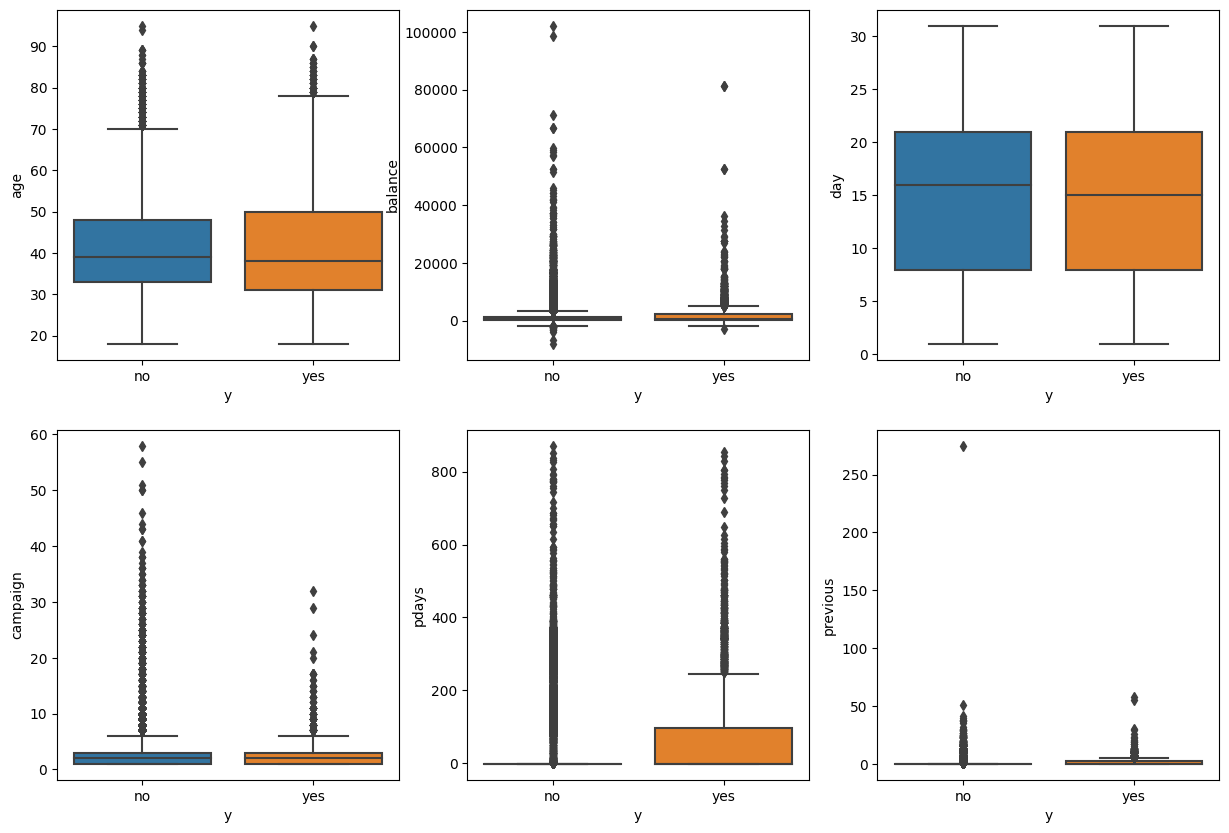

In [28]:
import seaborn as sns

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(15,10))

sns.boxplot(x='y',y='age', data=df, ax=ax1)
sns.boxplot(x='y',y='balance', data=df, ax=ax2)
sns.boxplot(x='y',y='day', data=df, ax=ax3)
sns.boxplot(x='y',y='campaign', data=df, ax=ax4)
sns.boxplot(x='y',y='pdays', data=df, ax=ax5)
sns.boxplot(x='y',y='previous', data=df, ax=ax6)

<Axes: xlabel='balance', ylabel='Count'>

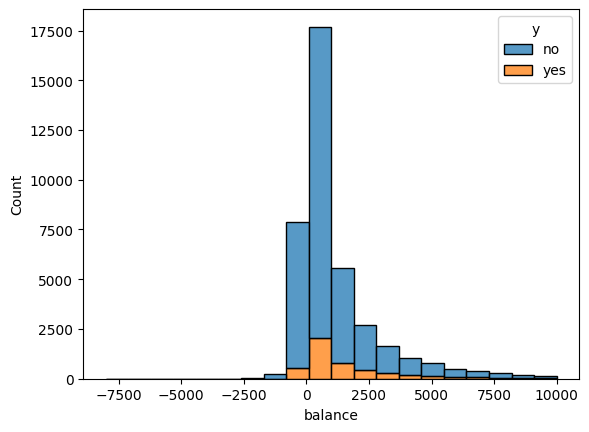

In [29]:
sns.histplot(data=df[(df['balance']<10000) & (df['balance'] != 0)], x='balance', hue='y', bins=20, multiple='stack')

For age, the mean (41) is close to the median (39) and hence we do not clear the outliers. For balance, the case with high balance (over $50k) tends to be negative and hence we keep those records with high balance to preserve the information. Thus, we propose to split the balance into different buckets and create a new categorical variable for predicting the success rate.

In [30]:
# create new variables based on balances
def bal_cat(x):
    if x <= 0:
        return 'null or negative'
    else:
        return 'positive'

df['bal_cat'] = df['balance'].apply(bal_cat)

For campaign, it represents the number of contacts made during this campaign. Like balance, the customer with high number of contacts tends to be negative. 

In [31]:
# create new variables based on balances
def camp_cat(x):
    if x <= 10:
        return '10 or below'
    else:
        return 'more than 10'

df['camp_cat'] = df['campaign'].apply(camp_cat)

'day' represent the calendar day of the call. The distribution is similar between positive and negative cases and hence this field would not be included in the prediction model.

'pdays' represent the days passed after the client last contact by the campaign. Majority of the value is -1 which indicate the client not contacted before. We will extract the records with 'pdays' not equal -1 to examine the relationship against target value. Further, we exclude the outlier with 'previous' > 250 since contacting the client over 100 times in one campaign is abnormal.

<Axes: xlabel='y', ylabel='pdays'>

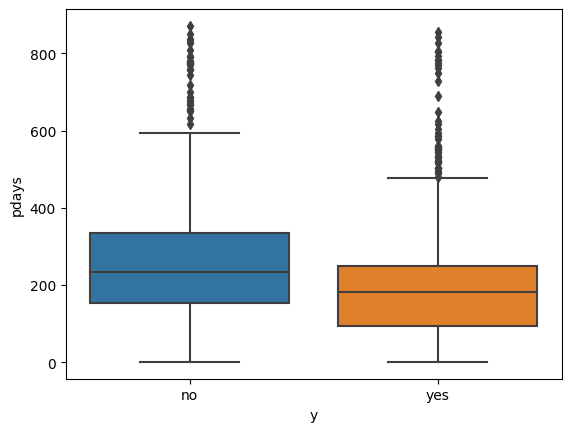

In [32]:
# examine the record who contacted before and exclude the outliers of 'previous' > 60
df_pday = df[(df['pdays'] > -1) & (df['previous'] < 60)]
sns.boxplot(x='y',y='pdays', data=df_pday)

<Axes: xlabel='y', ylabel='previous'>

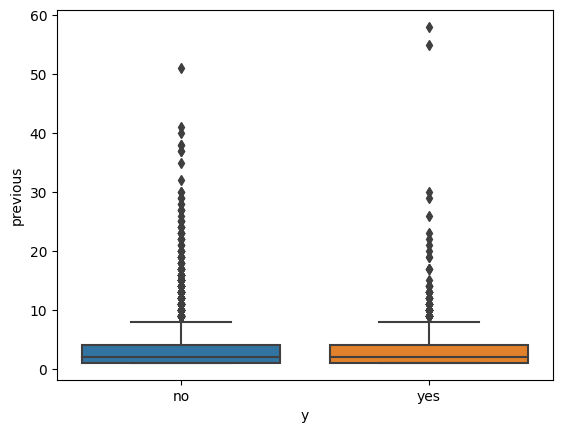

In [33]:
sns.boxplot(x='y',y='previous', data=df_pday)

Based on the records which clients are contacted before, the higher value of 'pdays', the higher probability of having negative result. However, the distribution of 'previous' is similar between positive and negative cases. Thus, we will not include 'previous' in our prediction model.

In [34]:
# revised numerical variable
num = ['age','pdays']

job  admin.  blue-collar  entrepreneur  housemaid  management  retired   
y                                                                        
no     4387         8603          1295       1090        7963     1659  \
yes     613          675           116        105        1253      486   

job  self-employed  services  student  technician  unemployed  
y                                                              
no            1358      3654      549        6538        1076  
yes            182       350      226         817         198  


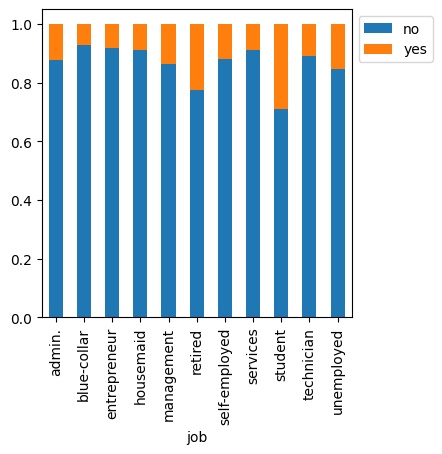

marital  divorced  married  single
y                                 
no           4430    23343   10399
yes           598     2603    1820


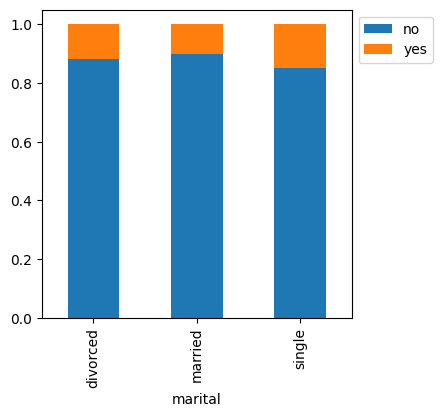

education  primary  secondary  tertiary
y                                      
no            6212      20690     11270
yes            588       2441      1992


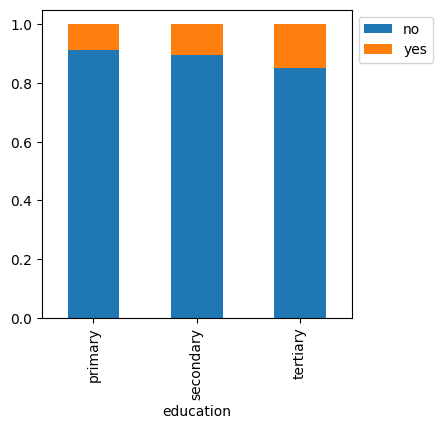

default     no  yes
y                  
no       37438  734
yes       4973   48


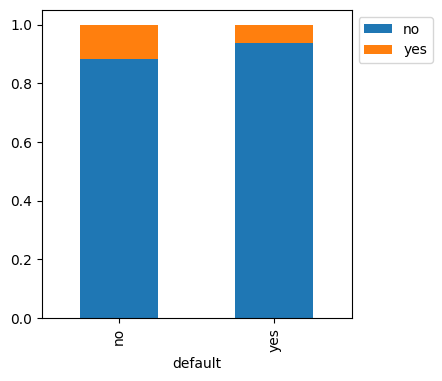

housing     no    yes
y                    
no       15754  22418
yes       3147   1874


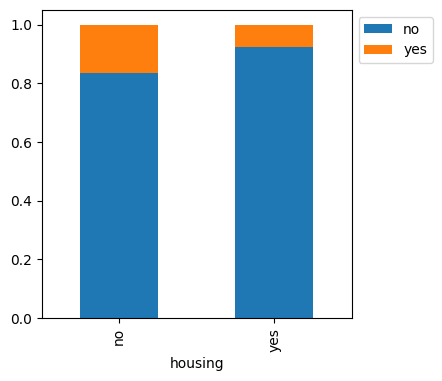

loan     no   yes
y                
no    31538  6634
yes    4548   473


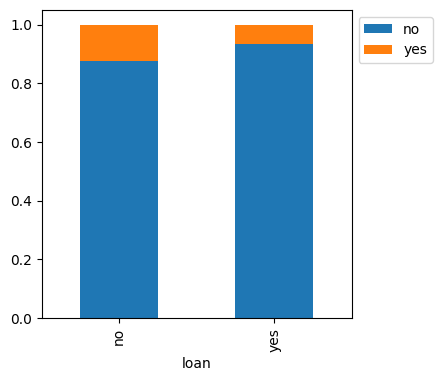

month   apr   aug  dec   feb   jan   jul   jun  mar    may   nov  oct  sep
y                                                                         
no     2277  5378  107  2115  1186  6015  4457  207  12304  3452  393  281
yes     543   659   93   418   132   586   523  241    888   390  297  251


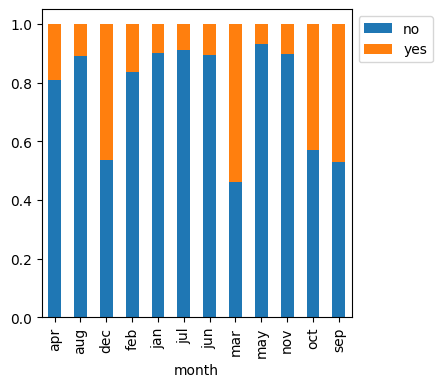

poutcome  failure  other  success
y                                
no           4122  33543      507
yes           587   3517      917


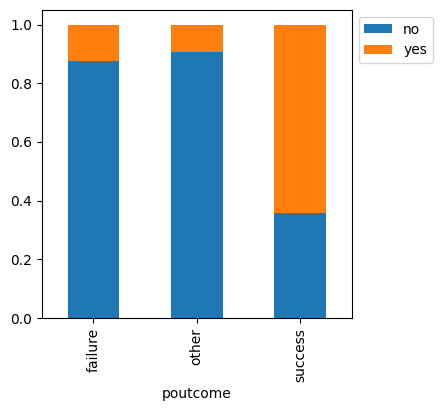

bal_cat  null or negative  positive
y                                  
no                   6509     31663
yes                   491      4530


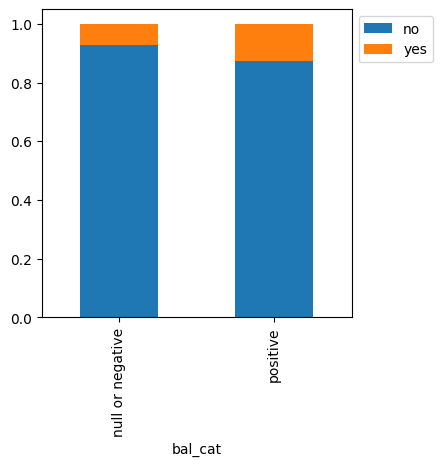

camp_cat  10 or below  more than 10
y                                  
no              37091          1081
yes              4976            45


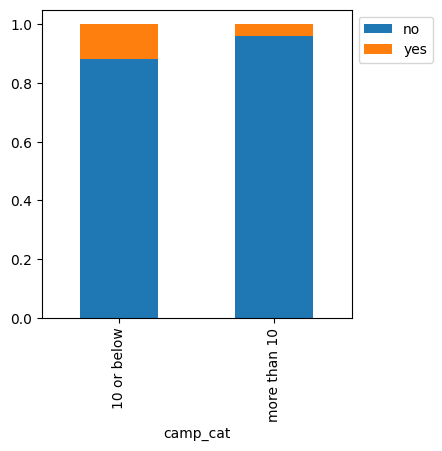

In [35]:
cat = ['job','marital','education','default','housing','loan','month','poutcome','bal_cat', 'camp_cat']

for i in cat:
    print(df.groupby(['y',i])['age'].count().unstack())
    df.groupby([i])['y'].value_counts(normalize=True).unstack().plot.bar(stacked=True, figsize=(4,4))
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

On 'job', 'student' and 'retired' have higher success rate. Hence, we group the categories into 'student', 'retired' and 'others'.

On 'marital', 'single' has slightly higher success rate.

On 'education', the higher the education, the higher the success rate.

On 'default', the non-default client has higher success rate.

On 'housing' and 'loan', the success rate is higher if the client does not have loan with the bank.

On 'month', there are certain months with high success rate, including Mar, Sep, Oct, and Dec. Hence, we will include this feature into the model.

On 'poutcome', the likelihood of success is higher if the result of previous campaign is success. Thus, we'll include this feature in the model.

In [36]:
# group the job into three categories
def job_cat(x):
    if x == 'student':
        return 'student'
    elif x == 'retired':
        return 'retired'
    else:
        return 'other'

df['job_cat'] = df['job'].apply(job_cat)

In [37]:
# updated categorical variables
cat = ['job_cat','marital','education','default','housing','loan','poutcome','bal_cat', 'camp_cat']

Next, we perform bi-variable analysis.

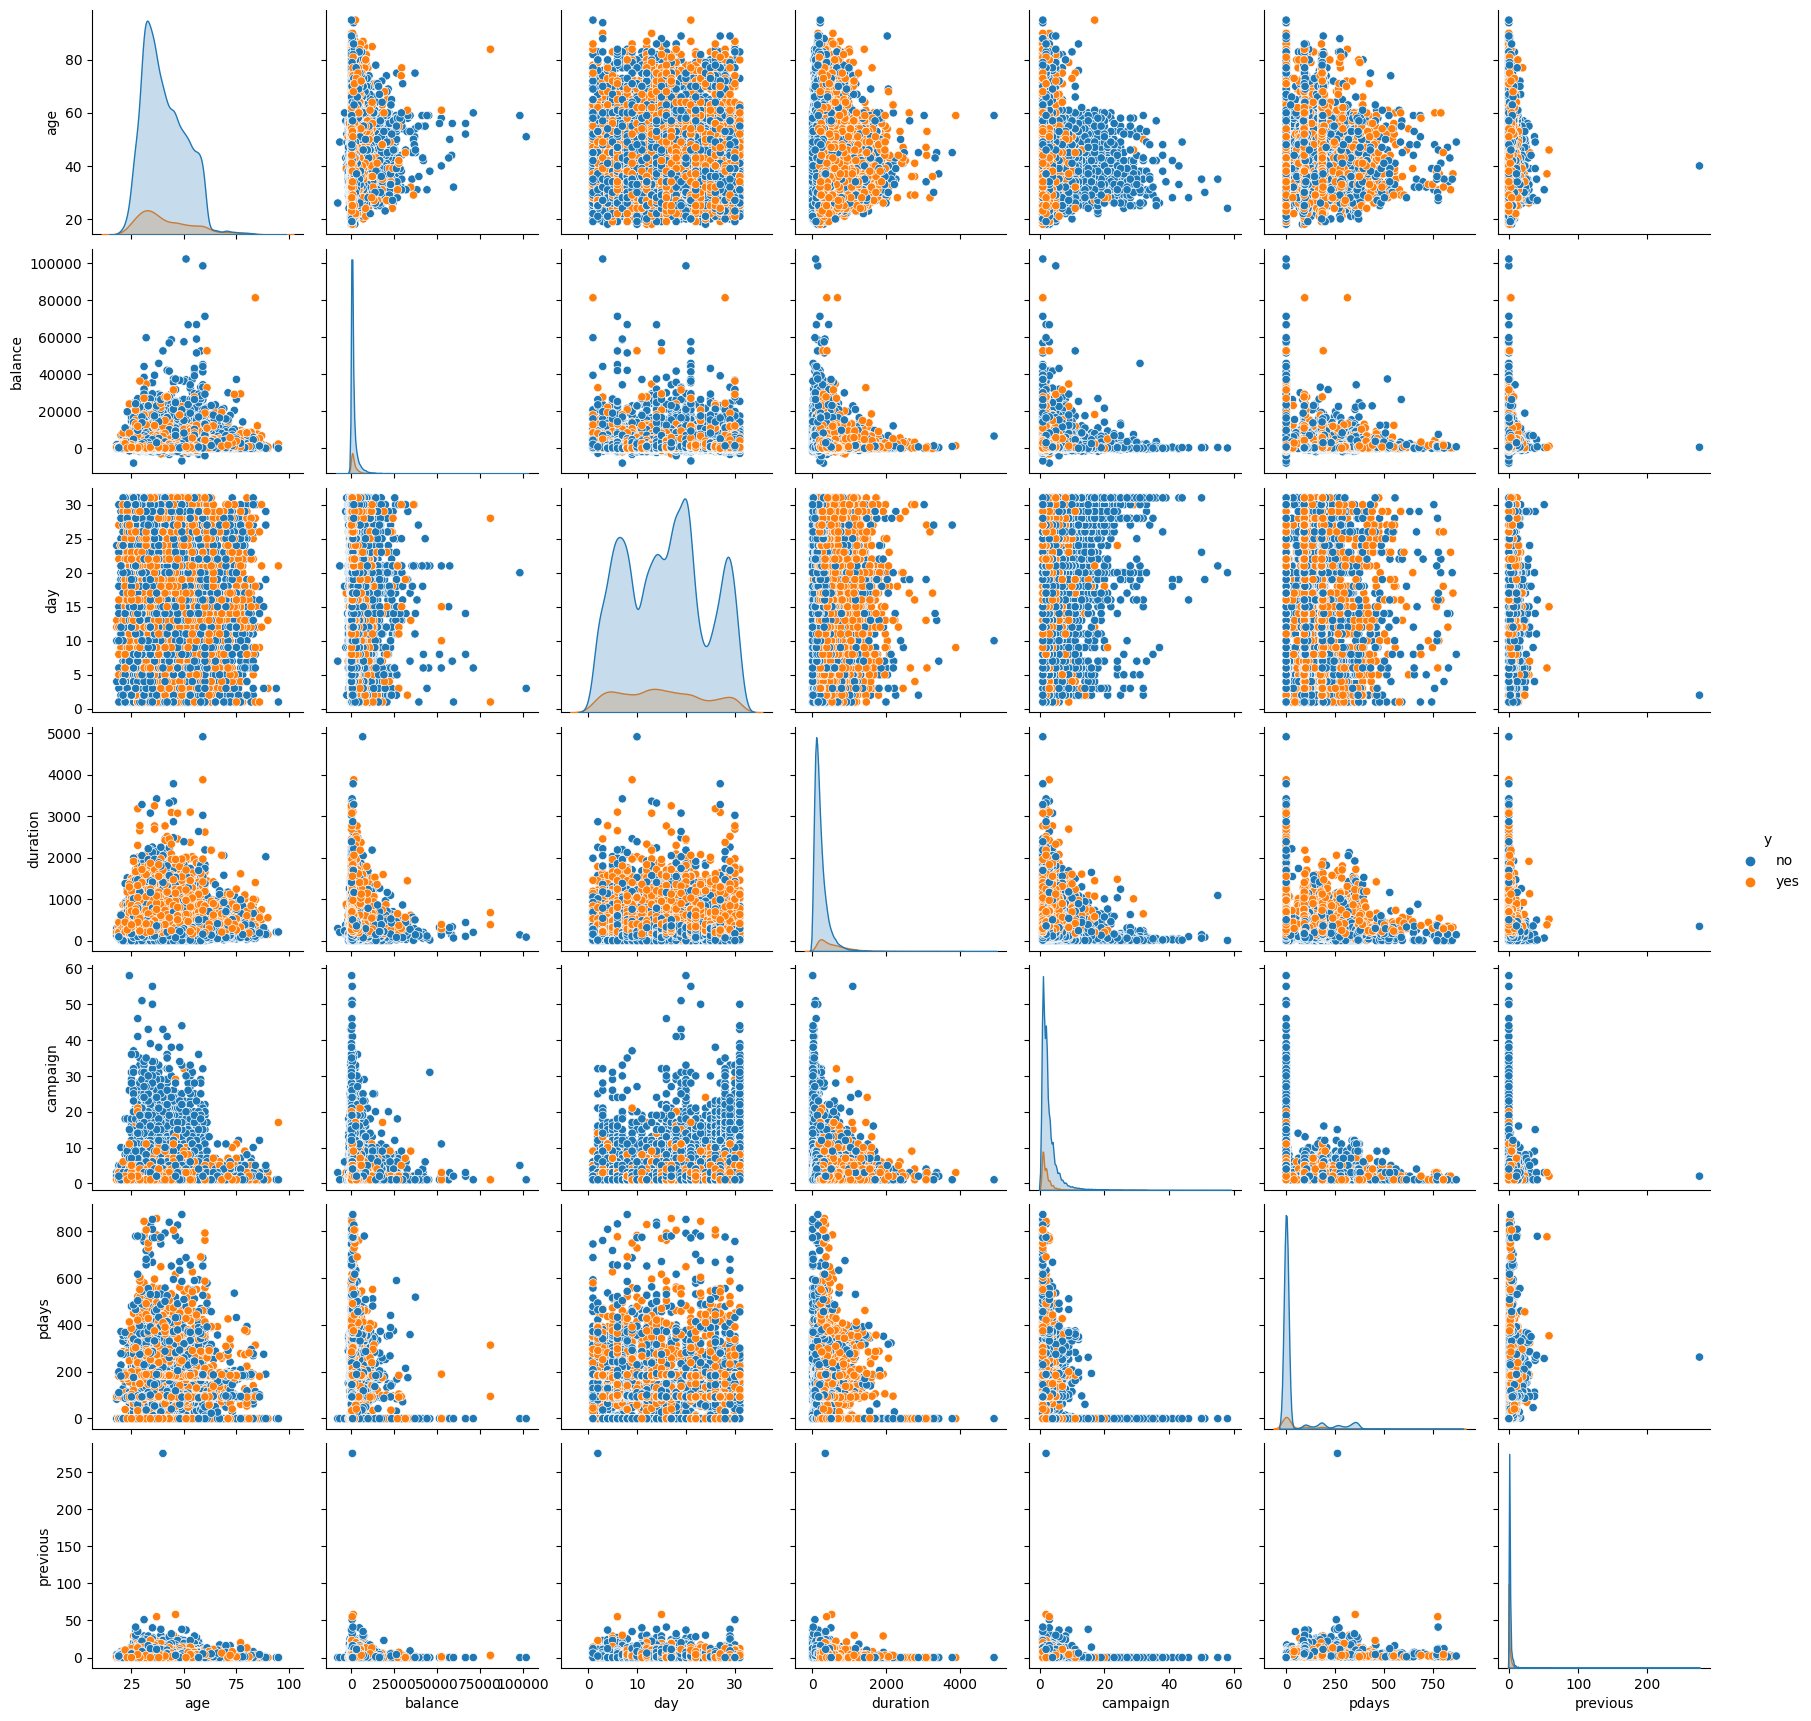

In [38]:
sns.pairplot(df, hue = 'y')

From the pairplot above, there is not much distinction between success and failure based on pdays and age. The samples tend to be negative if the campaign value is high.

# Part 1B: Build a pipeline to preprocess and transform the data

<Axes: xlabel='y', ylabel='Count'>

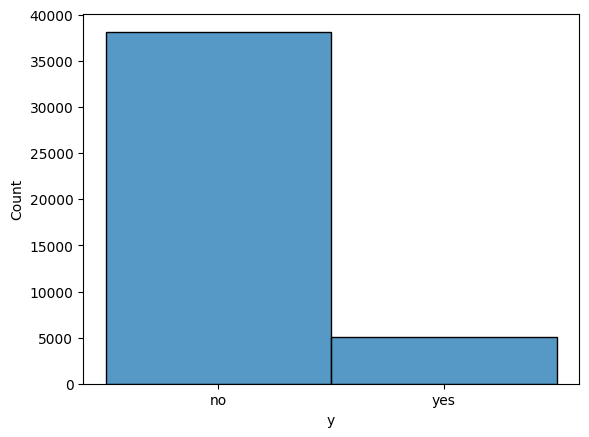

In [39]:
# review whether the target value is balanced
sns.histplot(data=df, x='y')

Based on the above the graph, the target value is highly imbalanced. Thus, we will apply the SMOTE when training the model. Further, standard scalar will be applied to the numerical value.

In [40]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Summarize the various features used for model building
num = ['age','pdays']
cat = ['job_cat','marital','education','default','housing','loan','poutcome', 'bal_cat', 'camp_cat', 'month']
target = 'y'

# Separate features and target
X = df[cat + num]
y = df[target]

# Transform target variable to 1 and 0 using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# build pipeline
cat_transformer = OneHotEncoder(handle_unknown='ignore')
num_transformer = StandardScaler()
preprocessor = ColumnTransformer(transformers = [('cat',cat_transformer, cat),
                                                 ('num', num_transformer, num)])

# Combine preprocessing and SMOTE in the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=1234))  # Include SMOTE in the pipeline
])

# Part 2A: Create baseline model: Logistic Regression and KNN

First, we split the data into training and testing dataset and apply the preprocessing steps in Part 1B. We then feed the training data into Logistic Regression and KNN model to generate a preliminary result. To ensure the model is not over-trained, we also perform 10-fold cross validation to detect any sign of overfitting.

In [41]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, classification_report, roc_auc_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Apply the pipeline on the training data
X_train_transformed, y_train_transformed = pipeline['smote'].fit_resample(pipeline['preprocessor'].fit_transform(X_train), y_train)
X_test_transformed = pipeline['preprocessor'].fit_transform(X_test)


In [42]:
# Initialize the baseline models
knn = KNeighborsClassifier()
log = LogisticRegression()

# Train the baseline models
knn.fit(X_train_transformed, y_train_transformed)
log.fit(X_train_transformed, y_train_transformed)

# Predict the baseline models
pred_knn = knn.predict(X_test_transformed)
pred_log = log.predict(X_test_transformed)

# Caculate the f1 score
print(f"f1_score for knn: {f1_score(y_test,pred_knn):.4f}")
print(f"f1_score for log: {f1_score(y_test,pred_log):.4f}")

f1_score for knn: 0.2895
f1_score for log: 0.3658


In [43]:
cv_scores_knn = cross_val_score(knn, X_train_transformed, y_train_transformed, cv=10, scoring='f1')
print("Cross-validation scores for KNN: ", [f"{score:.4f}" for score in list(cv_scores_knn)])
print("CV Score spread for KNN: ", f"{max(cv_scores_knn) - min(cv_scores_knn):.4f}\n")

cv_scores_log = cross_val_score(log, X_train_transformed, y_train_transformed, cv=10, scoring='f1')
print("Cross-validation scores for LogisticReg: ", [f"{score:.4f}" for score in list(cv_scores_log)])
print("CV Score spread for LogisticReg: ", f"{max(cv_scores_log) - min(cv_scores_log):.4f}\n")


Cross-validation scores for KNN:  ['0.7209', '0.7708', '0.8088', '0.7971', '0.8060', '0.7885', '0.7880', '0.7999', '0.8047', '0.7914']
CV Score spread for KNN:  0.0879

Cross-validation scores for LogisticReg:  ['0.6464', '0.6530', '0.6480', '0.6549', '0.6544', '0.6406', '0.6440', '0.6619', '0.6422', '0.6551']
CV Score spread for LogisticReg:  0.0213



Based on the preliminary result above, logistic regression has higher f1_score and lower variance compared against KNN model. Next, we will fine-tune the baseline model to see if the result could be improved.

# Part 2B: Tune the  baseline models

We apply randomized search to find the best hyperparameters for KNN and Logistic Regression model. For KNN model, we search for the optimal value for different n_neighbors and different weights method. For logistic regression, we search for the optimal solver and degree of regularization.

For each search, we apply 10-fold cross validation and find the best hypermeters setting with standard deviation less than 5% to avoid overfitting.

In [56]:
import warnings
from sklearn.model_selection import RandomizedSearchCV


params_knn = {'n_neighbors': list(range(1,1000)), 'weights': ['uniform', 'distance']}
knn = KNeighborsClassifier()

# initiate the randomsearch and hide the warning for better readability
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    randomsearch_knn = RandomizedSearchCV(knn, params_knn, cv=10, n_iter = 100, scoring='f1', random_state=1234)
    randomsearch_knn.fit(X_train_transformed, y_train_transformed)

# Extract CV results and calculate the mean (for maximizing) and std_scores (for model stability)
cv_results = randomsearch_knn.cv_results_
mean_scores = cv_results['mean_test_score']
std_scores = cv_results['std_test_score']

# Find the indices where the difference in CV scores is within 0.1 std score
stable_indices = [i for i, std in enumerate(std_scores) if std <= 0.05]

# Select the hyperparameter set with the highest mean score among the stable ones
if stable_indices:
    best_stable_index = max(stable_indices, key=lambda x: mean_scores[x])
    best_params = cv_results['params'][best_stable_index]
    print("Best stable parameters:", best_params)
else:
    print("No stable parameter combinations found.")

Best stable parameters: {'weights': 'distance', 'n_neighbors': 11}


Result from the LogisticRegression Randomized search (61mins):

Best stable parameters: {'weights': 'distance', 'n_neighbors': 11}

In [45]:
params_log = {
    'penalty': ['l1', 'l2','elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['newton-cg', 'lbfgs', 'newton-cholesky', 'sag', 'saga'],
}
log = LogisticRegression()

# initiate the randomsearch and hide the warning for better readability
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    randomsearch_log = RandomizedSearchCV(log, params_log, cv=10, n_iter = 100, scoring='f1', random_state=1234)
    randomsearch_log.fit(X_train_transformed, y_train_transformed)

# Extract CV results and calculate the mean (for maximizing) and std_scores (for model stability)
cv_results = randomsearch_log.cv_results_
mean_scores = cv_results['mean_test_score']
std_scores = cv_results['std_test_score']

# Find the indices where the difference in CV scores is within 0.1 std score
stable_indices = [i for i, std in enumerate(std_scores) if std <= 0.05]

# Select the hyperparameter set with the highest mean score among the stable ones
if stable_indices:
    best_stable_index = max(stable_indices, key=lambda x: mean_scores[x])
    best_params = cv_results['params'][best_stable_index]
    print("Best stable parameters:", best_params)
else:
    print("No stable parameter combinations found.")

Best stable parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}


Result from the LogisticRegression Randomized search (3mins):

Best stable parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}

# Part 2C: Evaluate the baseline models

After the Randomized Search, we compare the model results before and after tuning.

In [55]:
# Initialize the baseline models
knn = KNeighborsClassifier()
knn_tuned = KNeighborsClassifier(weights='distance', n_neighbors=11)
log = LogisticRegression()
log_tuned = LogisticRegression(solver='lbfgs', penalty='l2', C=0.01)

# Train the baseline models
knn.fit(X_train_transformed, y_train_transformed)
knn_tuned.fit(X_train_transformed, y_train_transformed)
log.fit(X_train_transformed, y_train_transformed)
log_tuned.fit(X_train_transformed, y_train_transformed)

# Predict the baseline models
pred_knn = knn.predict(X_test_transformed)
pred_knn_tuned = knn_tuned.predict(X_test_transformed)
pred_log = log.predict(X_test_transformed)
pred_log_tuned = log_tuned.predict(X_test_transformed)

# Caculate the f1 score
print(f"f1_score for knn: {f1_score(y_test,pred_knn):.4f}")
print(f"f1_score for knn_tuned: {f1_score(y_test,pred_knn_tuned):.4f}")
print(f"f1_score for log: {f1_score(y_test,pred_log):.4f}")
print(f"f1_score for log_tuned: {f1_score(y_test,pred_log_tuned):.4f}")

# Caculate the auc score
print(f"auc_score for knn: {roc_auc_score(y_test,pred_knn):.4f}")
print(f"auc_score for knn_tuned: {roc_auc_score(y_test,pred_knn_tuned):.4f}")
print(f"auc_score for log: {roc_auc_score(y_test,pred_log):.4f}")
print(f"auc_score for log_tuned: {roc_auc_score(y_test,pred_log_tuned):.4f}")

f1_score for knn: 0.2895
f1_score for knn_tuned: 0.2997
f1_score for log: 0.3658
f1_score for log_tuned: 0.3593
auc_score for knn: 0.6249
auc_score for knn_tuned: 0.6322
auc_score for log: 0.6829
auc_score for log_tuned: 0.6804


To evaluate the baseline model, we first determine the evaluation metrics and compare the metrics across the models. We then review the cross-validation result to ensure there is no over-fitting happened.

For the bank marketing purpose, we would like to cover as much as clients subscribing to the term deposits to ensure the campaign is effective, while also maximize the accuracy of prediction to achieve high marketing efficiency. Hence, we propose to use the F1 score, which balance between precision and recall achieving both objectives.

The f1 score of KNN model increased slightly after hyperparameter tuning, while that of logistic regression model decrease slightly. Logistic regression demonstrates both a higher f1 score and higher auc_score than KNN model. Thus, it will form our baseline model for comparison.

# Part 3: Ensemble modelling: Random Forest, AdaBoost, Bagging, Voting

To further improve the result, we build four ensembled model for further review, including random forest classifier, adaptive boosting, bagging, and voting. Each of them has different ensemble methods as explained below.

Random Forest Classifier use multiple random subsets of data and features to build multiple trees and average the outcome to arrive the results. The method introduces randomness in both training data and features to improve model generalization.

Adaptive boosting uses a sequence of shallow decision tree (a.k.a. weak learner) to predict the result. It will optimize the result by training a sequence of weak learners improving the previous mistakes by increasing the weight of incorrectly predicted samples. The weak learners will be weighted by their accuracy and combined at the end to arrive the results.

Bagging use a random subset of training data to construct multiple decision trees. The result will then be combined through majority voting to derive the results.

Voting use multiple baseline model and apply a voting mechanism to derive the results. The voting mechanism could be hard, i.e., majority voting, or soft, i.e., weighted average probabilities.

In [47]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=20)
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
bag = BaggingClassifier()
voting = VotingClassifier(estimators=[('lr', log), ('knn', knn_tuned), ('dt', dt)])

In [48]:
classifiers = {
    'K-Nearest Neighbors': knn_tuned,
    'Logistic Regression': log,
    'Decision Tree': dt,
    'Random Forest': rf,
    'AdaBoost': ada,
    'Bagging': bag,
    'Voting': voting
}

# Create dictionary to store the results of each model
results = {}

In [49]:
import time # to measure how long the models take

# Loop through list of models to compare performance
for name, clf in classifiers.items():
    start_time = time.time()
    
    # Fit the model
    clf.fit(X_train_transformed, y_train_transformed)
    
    # Make predictions
    y_pred = clf.predict(X_test_transformed)
    
    # Compute metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # Store results
    results[name] = {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Accuracy': accuracy,
        'Time (s)': elapsed_time
    }

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results).T
print(results_df)

                     Precision    Recall  F1-Score  Accuracy  Time (s)
K-Nearest Neighbors   0.206679  0.545010  0.299704  0.698692  1.550218
Logistic Regression   0.267542  0.578278  0.365831  0.762820  0.527123
Decision Tree         0.158928  0.562622  0.247845  0.596018  0.502265
Random Forest         0.152267  0.558708  0.239313  0.579812  7.243866
AdaBoost              0.264813  0.568493  0.361318  0.762241  3.191602
Bagging               0.120034  0.691781  0.204572  0.363584  2.706755
Voting                0.244968  0.559687  0.340780  0.743836  1.896090


The above results show that AdaBoost provides the highest F1-Score, precision, and accuracy. However, its processing time is the second highest (3secs). Both random forest and bagging provide a lower f1 score than the baseline model while the score of voting is slightly worse than logistic regression but better than the KNN model.

Next, we will apply grid search to explore whether the results might further improve by trying different n_estimators, i.e., the simple models used in the ensemble methods. Like the baseline models, we will also perform cross validation to check whether there is any overfitting issue.

In [50]:
# tune the ensembled model

# Import additional libraries
from sklearn.model_selection import GridSearchCV

classifiers = {
    'Random Forest': rf,
    'AdaBoost': ada,
    'Bagging': bag,
    'Voting': voting
}

# Hyperparameter grids for tuning
rf_params = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 30, 50]}
ada_params = {'n_estimators': [25, 50, 75]}
bag_params = {'n_estimators': [5, 10, 20]}
voting_params = {'voting': ['hard', 'soft']}

params_dict = {
    'Random Forest': rf_params,
    'AdaBoost': ada_params,
    'Bagging': bag_params,
    'Voting': voting_params
}

# Initialize results dictionary for tuned models
tuned_results = {}

# Loop through classifiers for tuning
for name, clf in classifiers.items():
    start_time = time.time()
    
    # Create GridSearchCV object
    grid = GridSearchCV(clf, params_dict[name], cv=5, scoring='f1')
    
    # Fit the model
    grid.fit(X_train_transformed, y_train_transformed)
    
    # Get the best estimator and predict
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_transformed)
    
    # Compute metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # Store results
    tuned_results[name] = {
        'Best Params': grid.best_params_,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Accuracy': accuracy,
        'Time (s)': elapsed_time
    }

# Convert results to DataFrame for easier viewing
tuned_results_df = pd.DataFrame(tuned_results).T
print(tuned_results_df)

                                          Best Params Precision    Recall   
Random Forest  {'max_depth': 50, 'n_estimators': 150}  0.151563  0.559687  \
AdaBoost                         {'n_estimators': 75}  0.252666   0.60274   
Bagging                          {'n_estimators': 20}  0.127095  0.727006   
Voting                             {'voting': 'soft'}  0.201599  0.567515   

               F1-Score  Accuracy    Time (s)  
Random Forest  0.238532  0.577266  301.118152  
AdaBoost       0.356069    0.7421   36.878713  
Bagging        0.216366  0.377011   40.299655  
Voting         0.297512  0.682949   20.837425  


In [51]:
# run the cross validation for tuned ensembled models
rf_tuned = RandomForestClassifier(n_estimators=100)
ada_tuned = AdaBoostClassifier(n_estimators=75)
bag_tuned = BaggingClassifier(n_estimators=20)
voting_tuned = VotingClassifier(estimators=[('lr', log), ('knn', knn_tuned), ('dt', dt)], voting='soft')

classifiers = {
    'Random Forest': rf_tuned,
    'AdaBoost': ada_tuned,
    'Bagging': bag_tuned,
    'Voting': voting_tuned
}

for name, clf in classifiers.items():
    cv_scores = cross_val_score(clf, X_train_transformed, y_train_transformed, cv=10, scoring='f1')
    print("Cross validation result of " +  name)
    print("Cross-validation scores: ", [f"{score:.4f}" for score in list(cv_scores)])
    print("CV Score spread: ", f"{max(cv_scores) - min(cv_scores):.4f}\n")


Cross validation result of Random Forest
Cross-validation scores:  ['0.6369', '0.8237', '0.8918', '0.8905', '0.8967', '0.8851', '0.8834', '0.8911', '0.8906', '0.8853']
CV Score spread:  0.2598

Cross validation result of AdaBoost
Cross-validation scores:  ['0.6396', '0.6939', '0.7112', '0.7239', '0.7212', '0.7020', '0.7043', '0.7156', '0.7045', '0.7155']
CV Score spread:  0.0843

Cross validation result of Bagging
Cross-validation scores:  ['0.5992', '0.8393', '0.9182', '0.9188', '0.9181', '0.9106', '0.9073', '0.9164', '0.9174', '0.9081']
CV Score spread:  0.3195

Cross validation result of Voting
Cross-validation scores:  ['0.6503', '0.7861', '0.8319', '0.8295', '0.8403', '0.8287', '0.8246', '0.8364', '0.8361', '0.8357']
CV Score spread:  0.1900



The above cross validations indicate that all the ensemble models, except for AdaBoost, have overfitting problem.

In [52]:
classifiers = {
    'K-Nearest Neighbors': knn_tuned,
    'Logistic Regression': log,
    'Decision Tree': dt,
    'Random Forest': rf,
    'AdaBoost': ada,
    'Bagging': bag,
    'Voting': voting,
    'Random Forest_tuned': rf_tuned,
    'AdaBoost_tuned': ada_tuned,
    'Bagging_tuned': bag_tuned,
    'Voting_tuned': voting_tuned
}

for name, clf in classifiers.items():
    start_time = time.time()
    
    # Fit the model
    clf.fit(X_train_transformed, y_train_transformed)
    
    # Make predictions
    y_pred = clf.predict(X_test_transformed)
    
    # Compute metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # Store results
    results[name] = {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Accuracy': accuracy,
        'Time (s)': elapsed_time
    }

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results).T
print(results_df)

                     Precision    Recall  F1-Score  Accuracy  Time (s)
K-Nearest Neighbors   0.206679  0.545010  0.299704  0.698692  1.723458
Logistic Regression   0.267542  0.578278  0.365831  0.762820  0.596770
Decision Tree         0.156847  0.562622  0.245307  0.590462  0.475607
Random Forest         0.150703  0.555773  0.237111  0.576919  7.340661
AdaBoost              0.264813  0.568493  0.361318  0.762241  2.999778
Bagging               0.128257  0.679061  0.215762  0.416020  2.631072
Voting                0.239749  0.560665  0.335873  0.737701  1.824264
Random Forest_tuned   0.150707  0.552838  0.236848  0.578539  7.125798
AdaBoost_tuned        0.252666  0.602740  0.356069  0.742100  4.499281
Bagging_tuned         0.124439  0.731898  0.212712  0.359069  5.300290
Voting_tuned          0.197997  0.580235  0.295245  0.672300  1.714736


#### Part 4: Model comparison: Computing resources vs model performance

In terms of computing resources, Random Forest consumed the most computing resources since it involves building multiple full versions of trees to derive the result. It takes 20x more time compared against the baseline logistic regression model (6.3 sec vs.. 0.3 sec). It, however, performs worse than the baseline and other ensemble models. Its f1 score is 0.25 only, which is the second lowest score among all the models trained.

In terms of model performance, the AdaBoost deliver the highest f1 score of 0.361, followed by logistic regression with f1 score of 0.359. The AdaBoost, however, also consume more computing resources than the baseline models. It takes 2.9 secs to run the model compared against 0.3 secs used by logistic regression model.

In general, all the ensembled model consumed more computing resources than the baseline models, but the improvement in performance is not guaranteed.

#### Part 5A: Explanation on the ensemble models performance

Among the ensemble models, AdaBoost generates the highest f1 score. The result aligns with our expectation since both random forest and bagging introduce additional randomness in the modelling process instead of focusing on improving the weaknesses of the model. Voting combines the result of different classifiers through majority voting or weighted average probability. The improvement in result is not guaranteed since the accuracy in one estimator may be offset by the error in another estimator.

In AdaBoost, each iteration focuses on fixing the error in previous iteration instead of introducing additional randomness in the previous model. Thus, the model performance is improved in each iteration. However, this method is prone to overfitting since each iterations increase the weight of misclassified samples in previous iteration. From the cross-validation result in Part 3, the difference between highest and lowest score is 0.08, which is wider than that of baseline logistic regression model (0.02).

# Part 5B: Model recommendation: Performance vs computation cost vs interpretability

We recommend the business to implement the baseline logistic regression model based on the below rationale:

1. The model delivered the second highest f1 score and accuracy. As explained in previous section, we would like to balance the effectiveness of the campaign (i.e., cover as much as subscribing clients possible) and the efficiency of the campaign (i.e., reduce the wastage from calling the non-subscribing clients). Thus, f1 score is used as the decision metrics. Despite bagging generates the highest recall score (70%), it has low precision (13% only) and high variance from the 10-fold cross validation results. On the other hand, logistic regression result in the least variance in the cross-validation.

2. Logistic regression consume the least computing resources (0.3 secs) compared against the AdaBoost model (2.9secs). Given AdaBoost only slightly improve the f1 score, the business does not worth to spend additional computing power. The costs could be material when the number of samples increase, and the campaign is running multiple times in a year. Apart from costs, the low computing power also allow the business to scale up the model as the businesses volume grows.

3. Logistic regression also has high interpretability since the coefficient of the model could be easily interpreted by the readers. It generates both the class and probability which is commonly understand by the readers without technical backgrounds. Further, it does not have the complexity from the ensemble methods which involves multiple iterations and aggregating the results of multiple weak learners.

Thus, logistic regression is recommended to the business for predicting whether a client will subscribe for time deposits through the telemarketing campaign.

# Part 5C: Decision criteria

The decision criteria of choosing the right model should be aligned with the business objectives of the campaign. If the bank is short of liquidity, its goal is to gather as much term deposits as possible and hence the criteria should focus on recall. If the bank's liquidity position is healthy and would like to gather term deposits at minimal costs, it should focus on the precision and spend the marketing effort on only those clients with high probability of subscription. In the above analysis, we assumed the bank want to balance both objective and hence f1-core is used as the decision criteria. As the circumstances change, we should update the model evaluation and adjust accordingly.

Apart from the performance metrics, computation costs should also be evaluated. The maintenance costs of the model will increase as the historical data accumulated.

Further, the bias vs variance trade-off should also be evaluated. For example, except for AdaBoost, the ensemble models after tuning have high variance on the cross-validation score which indicates the sign of overfitting. Hence, apart from the chosen evaluation metric and computation cost, we should also review whether the model is general enough to generate a consistent result on different data when deployed into the production.

In the precision-recall trade-off curve below, logistic regression and adaptive boosting are closest to the top right corner, which is align with our recommendation.

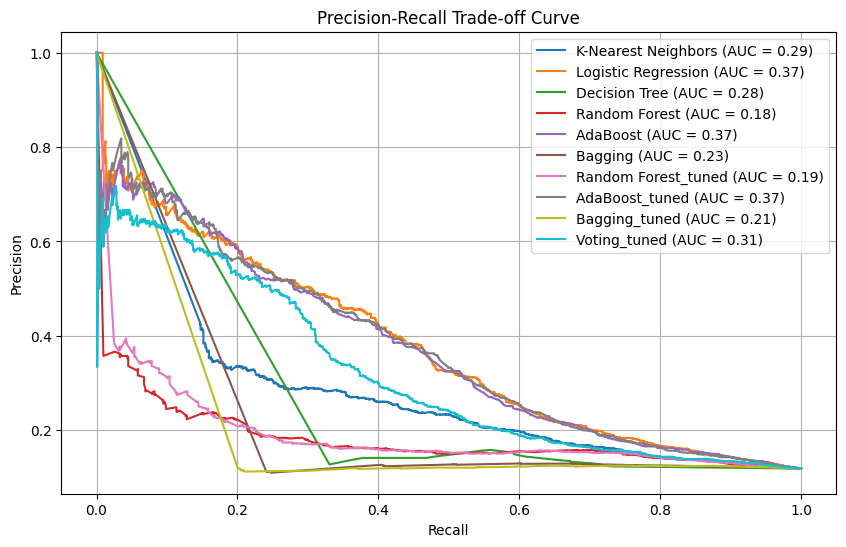

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# Define a dictionary of models
models = {
    'K-Nearest Neighbors': knn_tuned,
    'Logistic Regression': log_tuned,
    'Decision Tree': dt,
    'Random Forest': rf,
    'AdaBoost': ada,
    'Bagging': bag,
    'Voting': voting,
    'Random Forest_tuned': rf_tuned,
    'AdaBoost_tuned': ada_tuned,
    'Bagging_tuned': bag_tuned,
    'Voting_tuned': voting_tuned
}

# Initialize a plot
plt.figure(figsize=(10, 6))

# Iterate through the models and plot PR curves
for model_name, model in models.items():
    if hasattr(model, "predict_proba"):
        # Some models have predict_proba method for probability estimates
        y_prob = model.predict_proba(X_test_transformed)[:, 1]
    elif hasattr(model, "decision_function"):
        # For models that don't have predict_proba, use decision function
        y_prob = model.decision_function(X_test_transformed)
    else:
        continue
    
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    auc_score = auc(recall, precision)
    
    plt.plot(recall, precision, label=f'{model_name} (AUC = {auc_score:.2f})')

# Plot settings
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Trade-off Curve')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()
